## Stepwise forward selection for sparse logistic regression

The heart disease data set is described at: <br>
https://archive.ics.uci.edu/ml/datasets/Heart+Disease

The course webpage has a file <code>heart.csv</code> that contains a more compact version of this data set with 303 data points, each of which has a 13-dimensional attribute vector $x$ (first 13 columns) and a binary label $y$ (final column). We’ll work with this smaller data set.

### A. Preparing the data and fitting an initial model

Load in the data set and randomly partition it into 200 training points and 103 test points. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
 
df = pd.read_csv('heart.csv')

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200, random_state=42) 

Fit a logistic regression model to the training data and display the coefficients of the model.

In [2]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty=None, max_iter=5000).fit(X_train, y_train)
print('Parameters of logistic regression model:')
print(clf.coef_, clf.intercept_)

Parameters of logistic regression model:
[[ 2.36832284e-02 -1.45278613e+00  9.98550599e-01 -1.04591673e-02
  -1.58868170e-03  3.22381295e-01  6.78977769e-01  1.80792760e-02
  -1.13207848e+00 -4.78620789e-01  9.94550715e-01 -1.62881266e+00
  -1.44854367e+00]] [1.06763684]


Assess the error on the test set

In [3]:
print('Test error: %0.3f' % (1 - clf.score(X_test, y_test)))

Test error: 0.184


Estimate the error by using 5-fold cross-validation on the training set.

In [4]:
from sklearn.model_selection import cross_val_score

folds = 10
accuracies = cross_val_score(LogisticRegression(penalty=None, max_iter=5000), 
                         X_train, y_train, cv=folds)
print('Individual accuracies:')
print(accuracies)
print('Error estimate from %d-fold CV: %0.3f' % (folds, 1 - np.mean(accuracies)))

Individual accuracies:
[0.95 0.85 0.9  0.75 0.9  0.75 1.   0.85 0.8  0.8 ]
Error estimate from 10-fold CV: 0.145


### B. Stepwise forward selection

Now, suppose we want a sparse solution: one that uses only a subset $S$ of the 13 coordinates. One way to do this is with $l_1$-regularized logistic regression. Another method, which we’ll investigate here, is stepwise forward selection. This is a greedy procedure that chooses one feature at a time. If we want $k$ features total, these features are selected as follows:

<ul>
  <li> Let $S$ be empty (this is the set of chosen features) </li>
  <li> Repeat $k$ times:
  <ul>
      <li>For every feature $f \notin S$: </li>
      <ul>
          <li> Estimate the error of a classifier based on features $S \cup \{f\}$ </li>
      </ul>
      <li> Select the feature $f$ with the smallest error estimate</li>
      <li> Add this feature to $S$ </li>
  </ul></li>
  <li> Now learn a model based only on features $S$ </li>
</ul>

(a) Use this procedure to find a $k$-sparse logistic regression solution for the heart disease data, for $k = 1, 2, \ldots, 13$. Create a single plot showing the test error and cross-validation error for all these values of $k$.

In [5]:
def ErrorEstimate(x,y,S):
    accuracies = cross_val_score(LogisticRegression(penalty=None, max_iter=5000), 
                               x.iloc[:,S], y, cv=5)
    return 1-np.mean(accuracies)

In [6]:
test_errors = []
cv_errors = []
S = []
for k in range(13):    
    # Find the next (kth) best feature to add
    best_feature = -1
    best_err = 1.0    
    for f in range(X_train.shape[1]):        
        if f not in S:
            err = ErrorEstimate(X_train, y_train, S + [f])
            if err < best_err:
                best_feature = f
                best_err = err
    # Add the feature to S and compute the test / CV error
    S.append(best_feature)
    cv_errors.append(best_err)
    X_train_S, X_test_S = X_train.iloc[:, S], X_test.iloc[:, S]
    clf_S = LogisticRegression(penalty=None, max_iter=5000).fit(X_train_S, y_train)
    test_errors.append(1 - clf_S.score(X_test_S, y_test))

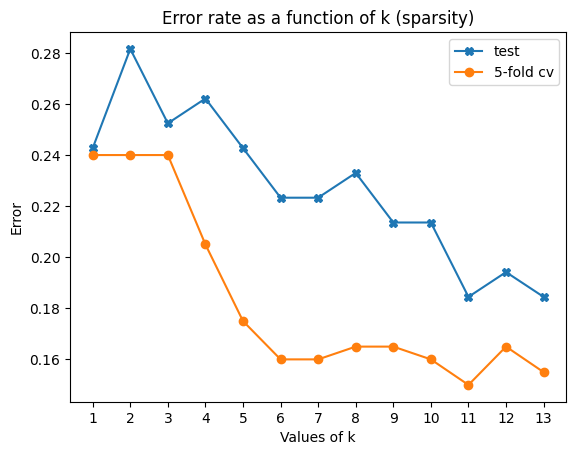

In [7]:
import matplotlib.pyplot as plt

plt.plot(list(range(1, 14)), test_errors, label='test', marker='X')
plt.plot(list(range(1, 14)), cv_errors, label='5-fold cv', marker='o')

plt.xticks(list(range(1, 14)))
plt.xlabel('Values of k')
plt.ylabel('Error')
plt.title('Error rate as a function of k (sparsity)')
plt.legend()

plt.show()

(b) What two features were chosen for $k = 2$? Plot the decision boundary in this case.

In [8]:
features = [df.columns.tolist()[i] for i in S[:2]]
S[:2], features

([2, 0], ['cp', 'age'])

In [9]:
X_train_2 = X_train.iloc[:, S[:2]]
clf_2 = LogisticRegression(penalty=None, max_iter=5000).fit(X_train_2, y_train)

clf_2.coef_, clf_2.intercept_

(array([[ 0.98839095, -0.038559  ]]), array([1.24701596]))

In [10]:
1 - clf_2.score(X_test.iloc[:, S[:2]], y_test)

0.2815533980582524

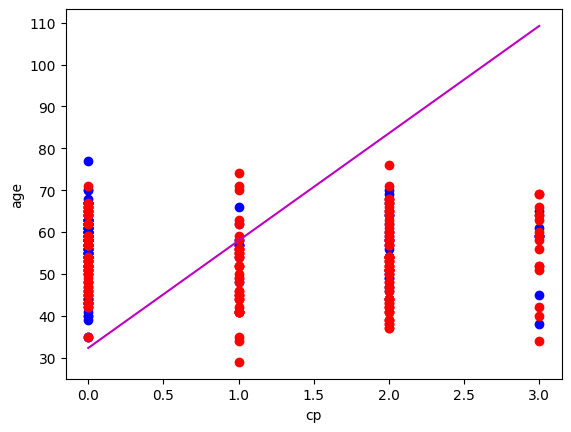

In [11]:
class0, class1 = df[df['target'] == 0], df[df['target'] == 1]
feature1, feature2 = features[0], features[1]

plt.scatter(class0[feature1], class0[feature2], c='b', label='Class 0')
plt.scatter(class1[feature1], class1[feature2], c='r', label='Class 1')

xmin, xmax = df[feature1].min(), df[feature1].max()
x = np.linspace(xmin, xmax, 100) 
y = (-clf_2.coef_[0][0] * x - clf_2.intercept_[0]) / clf_2.coef_[0][1]
plt.plot(x, y, label='decision_boundary', c='m')

plt.xlabel(feature1)
plt.ylabel(feature2)
# plt.legend()
plt.show()